In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from os.path import exists
import matplotlib.pyplot as plt
lr = 0.5 #скорость обучения
batch_size = 256
dtype = torch.float
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

In [2]:
def loss_plot(fig, ax, train_loss, test_loss, loss_name):
    train_line = ax.plot(train_loss, color = 'black')
    test_line = ax.plot(test_loss, color = 'red')
    #рисуем вертикальные линии с эпохами
    i = 1
    while i * len(train_loader) < len(train_loss):
        ax.axvline(i * len(train_loader), linestyle = '--')
        i += 1
    ax.set_xlabel('Батч')
    ax.set_ylabel(loss_name)
    ax.legend(('Тренировочная выборка', 'Тестовая выборка'))
    fig.canvas.draw()

In [3]:
download = not exists('./data')
train_set = datasets.MNIST(root='./data', train=True, download=download, transform=None)
test_set = datasets.MNIST(root='./data', train=False, download=download, transform=None)
x_train, y_train = train_set.data, train_set.targets
x_test, y_test = test_set.data, test_set.targets
#переводит во float и по надобности перекидывает на видеокарту
x_train = x_train.float().to(device)
x_test = x_test.float().to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [4]:
x_train = x_train.reshape(-1, 28*28)/255
x_test = x_test.reshape(-1, 28*28)/255

In [5]:
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size,shuffle=True)

In [6]:
model = torch.nn.Sequential(
    torch.nn.Linear(28*28, 10),
).to(device)
#нужно предварительно создать оптимайзер на параметры
#оптимайзер - это штука, которая на основе градиентов каким-то образом обновляет параметры
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
#кросс-энтропия сама делает softmax для y_hat!(ну это только в торче, внимательнее)
cross_entropy = torch.nn.CrossEntropyLoss()


<IPython.core.display.Javascript object>


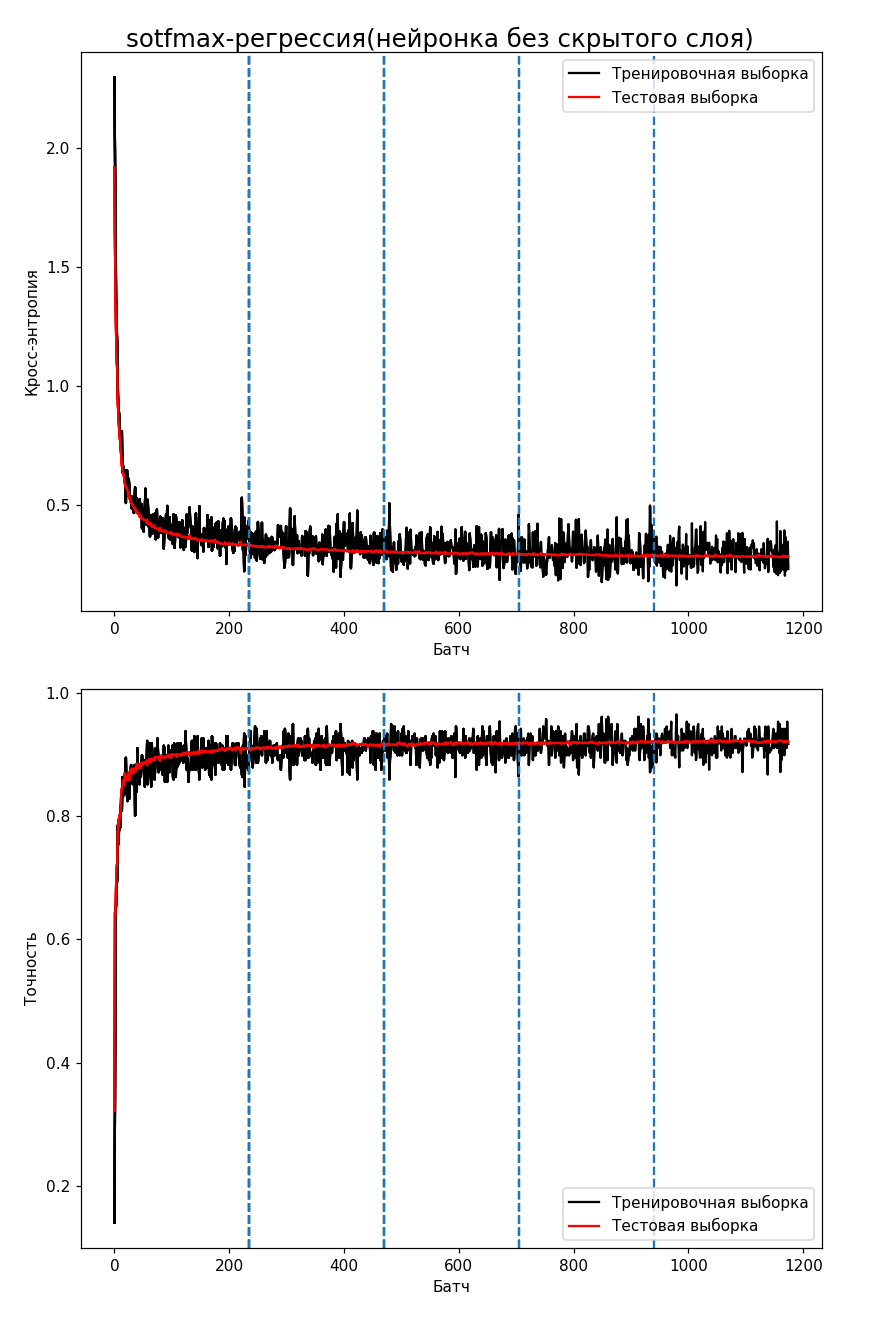

In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(8,12))
ax = fig.subplots(2,1)
fig.tight_layout(pad=3.0)

ax1, ax2 = ax
train_loss = []
test_loss = []
train_acc = []
test_acc = []
epochs = 5
for i in range(epochs):
    for x, y in train_loader:
        y_hat = model(x)
        loss = cross_entropy(y_hat, y)
        train_loss.append(loss.item())
        train_acc.append(
            torch.mean((y == torch.argmax(y_hat, 1)).float()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_hat = model(x_test)
            test_loss.append(cross_entropy(y_hat, y_test))
            test_acc.append(
                torch.mean((y_test == torch.argmax(y_hat, 1)).float()))
    

    fig.suptitle('sotfmax-регрессия(нейронка без скрытого слоя)', fontsize=16)
    loss_plot(fig,ax1,train_loss, test_loss, "Кросс-энтропия")
    loss_plot(fig,ax2,train_acc, test_acc, "Точность")

In [8]:
#найдём примеры, на которых модель дохнет
with torch.no_grad():
    y_hat = model(x_test)
    predicted = torch.argmax(y_hat, 1)
    bad_pictures = x_test[y_test != predicted].to('cpu').numpy()

<IPython.core.display.Javascript object>


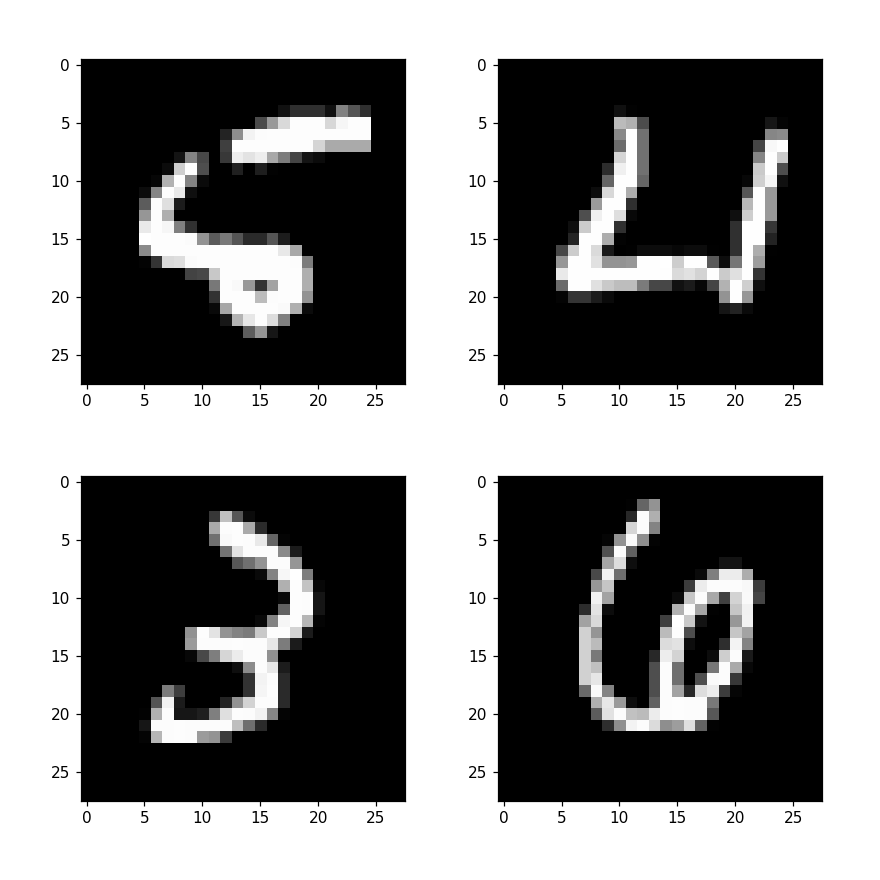

Настоящие метки tensor([5, 4, 3, 6], device='cuda:0')
Предсказанные метки tensor([6, 0, 2, 2], device='cuda:0')


In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(2,2)
fig.tight_layout(pad=3.0)
for i in range(4):
    ax[i // 2][i % 2].imshow(bad_pictures[i].reshape(28, 28), cmap='gray')
print(f'Настоящие метки {y_test[y_test != torch.argmax(y_hat, 1)][:4]}')
print(f'Предсказанные метки {predicted[y_test != predicted][:4]}')